In [28]:
import os

%matplotlib inline

import torch
import torch.nn as nn
import numpy as np

import random
import matplotlib.pyplot as plt
import pandas as pd
from config import get_cfg_defaults

from kale.utils.download import download_file_by_url
from kale.loaddata.image_access import read_dicom_images
from kale.interpret import visualize
from kale.embed.mpca import MPCA

from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.lines as mlines
import scipy.integrate as integrate
import torchvision.models as models


from sklearn.model_selection import cross_validate
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from kale.pipeline.mpca_trainer import MPCATrainer
from sklearn.calibration import CalibratedClassifierCV

In [2]:
import sys
sys.path.append('../')
from reliability_diagrams import *

In [3]:
cfg_path = "pykale/examples/cmri_mpca/configs/tutorial_svc.yaml" # Path to `.yaml` config file

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  BASE_DIR: SA_64x64
  FILE_FORAMT: zip
  IMG_DIR: DICOM
  LANDMARK_FILE: landmarks_64x64.csv
  MASK_DIR: Mask
  ROOT: ../data
  SOURCE: https://github.com/pykale/data/raw/main/images/ShefPAH-179/SA_64x64.zip
IM_KWARGS:
  cmap: gray
MARKER_KWARGS:
  marker: o
  markeredgecolor: r
  markeredgewidth: 1.5
  markerfacecolor: (1, 1, 1, 0.1)
OUTPUT:
  ROOT: ./outputs
PIPELINE:
  CLASSIFIER: svc
PROC:
  SCALE: 2
WEIGHT_KWARGS:
  alpha: 0.7
  markersize: 6


In [4]:
base_dir = cfg.DATASET.BASE_DIR
file_format = cfg.DATASET.FILE_FORAMT
download_file_by_url(cfg.DATASET.SOURCE, cfg.DATASET.ROOT, "%s.%s" % (base_dir, file_format), file_format)

In [5]:
img_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.IMG_DIR)
images = read_dicom_images(img_path, sort_instance=True, sort_patient=True)

mask_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.MASK_DIR)
mask = read_dicom_images(mask_path, sort_instance=True)

/opt/anaconda3/lib/python3.8/site-packages/pydicom/filereader.py:354: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(msg + f" - using {found_vr} VR for reading", UserWarning)


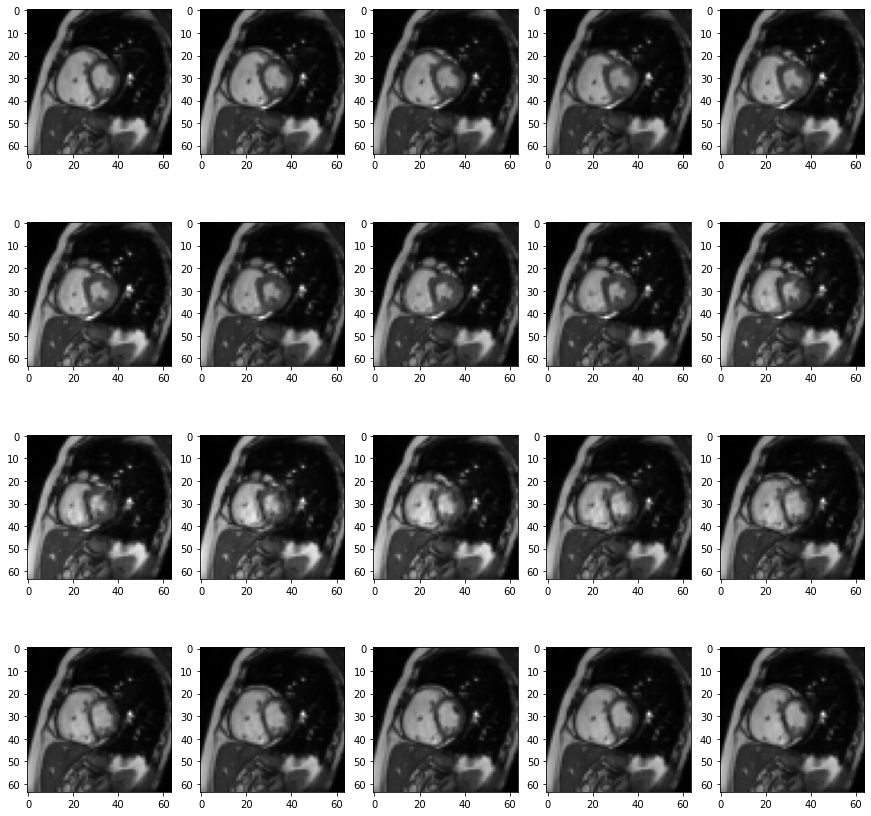

In [6]:
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(images[i][j-1], cmap="gray")

In [7]:
landmark_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.LANDMARK_FILE)
landmark_df = pd.read_csv(landmark_path, index_col="Subject")  # read .csv file as dataframe
landmarks = landmark_df.iloc[:, :6].values
y = landmark_df["Group"].values
y[np.where(y != 0)] = 1 

<ipython-input-8-cb37799eaa8b>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize.plot_multi_images(


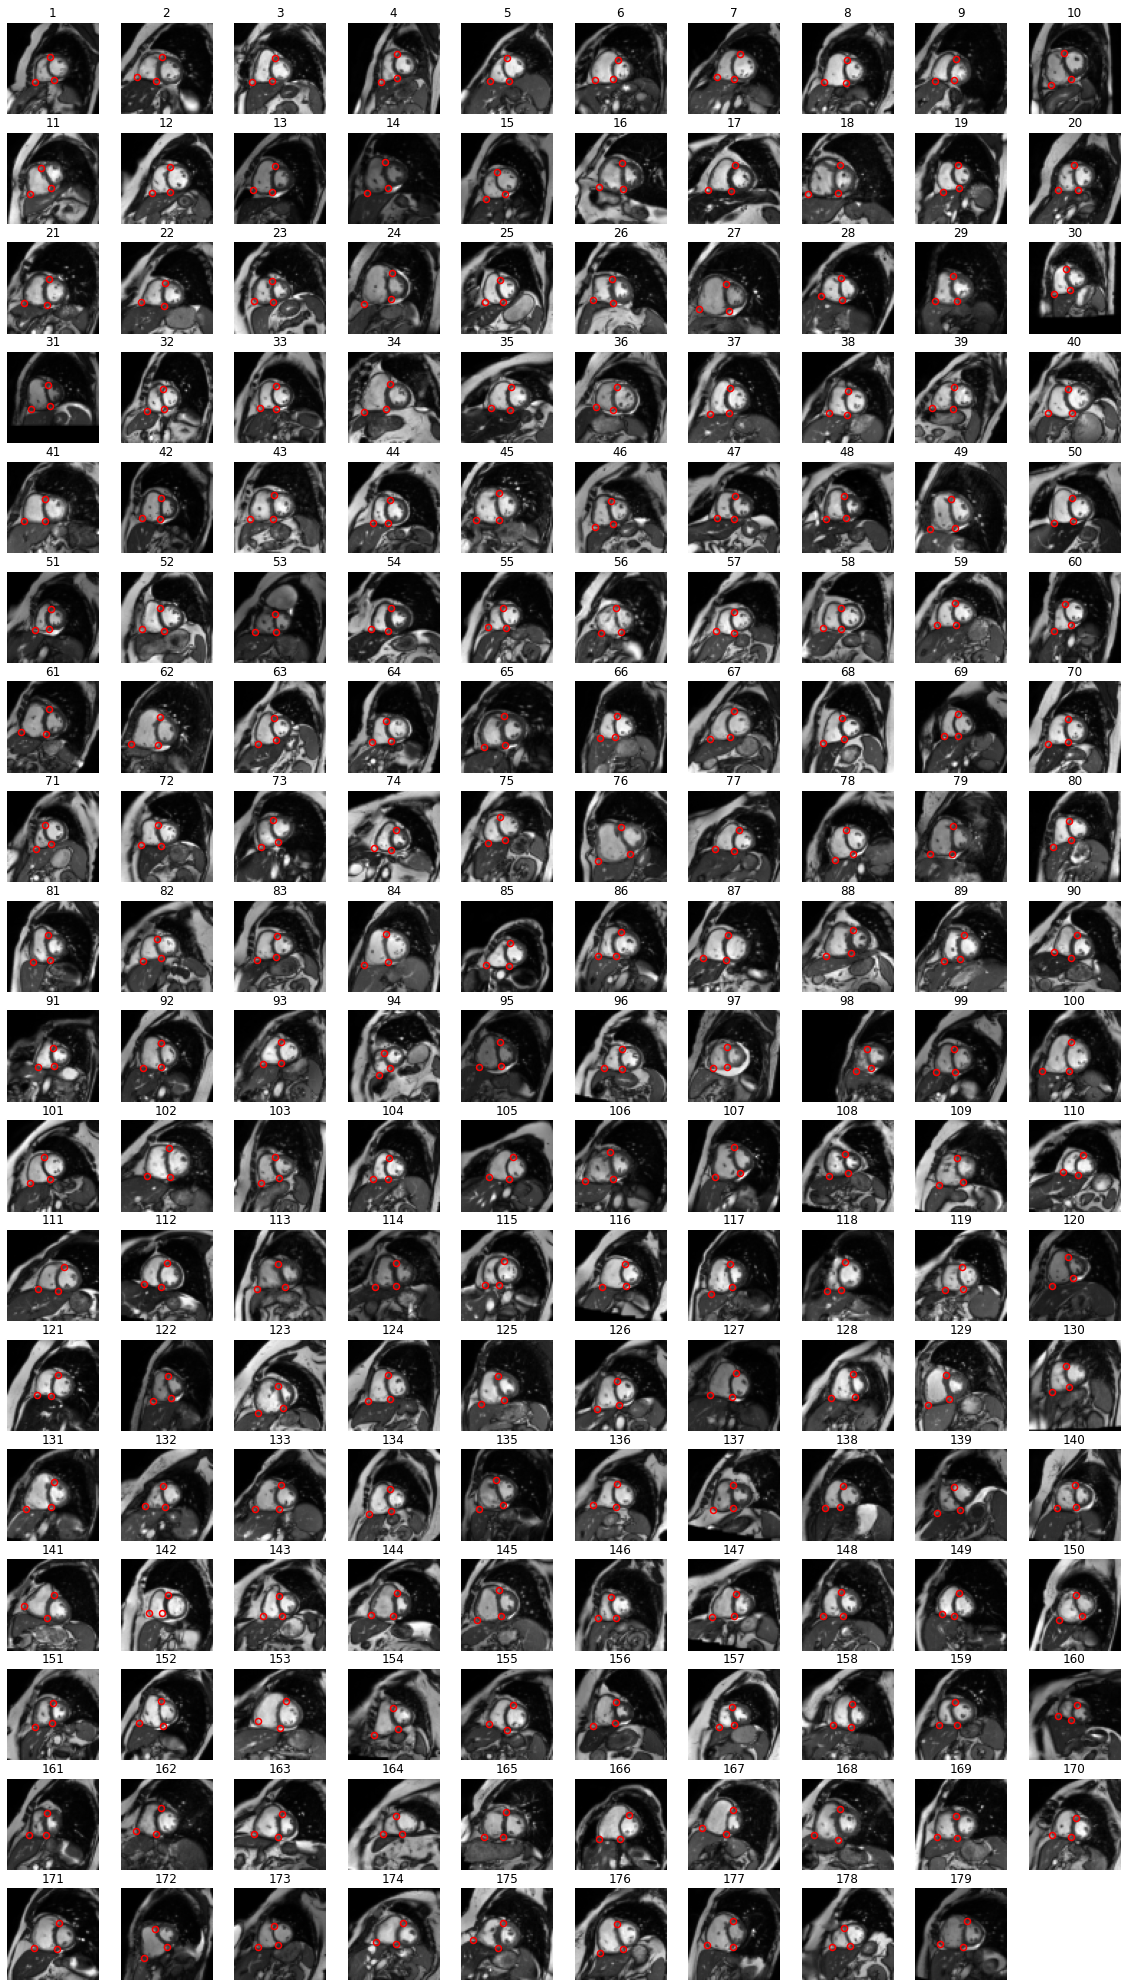

In [8]:

visualize.plot_multi_images(
    images[:, 0, ...], marker_locs=landmarks, im_kwargs=dict(cfg.IM_KWARGS), marker_kwargs=dict(cfg.MARKER_KWARGS)
).show()

In [9]:
from kale.prepdata.image_transform import mask_img_stack, normalize_img_stack, reg_img_stack, rescale_img_stack

In [10]:
img_reg, max_dist = reg_img_stack(images.copy(), landmarks)

In [11]:
img_masked = mask_img_stack(img_reg.copy(), mask[0, 0, ...])

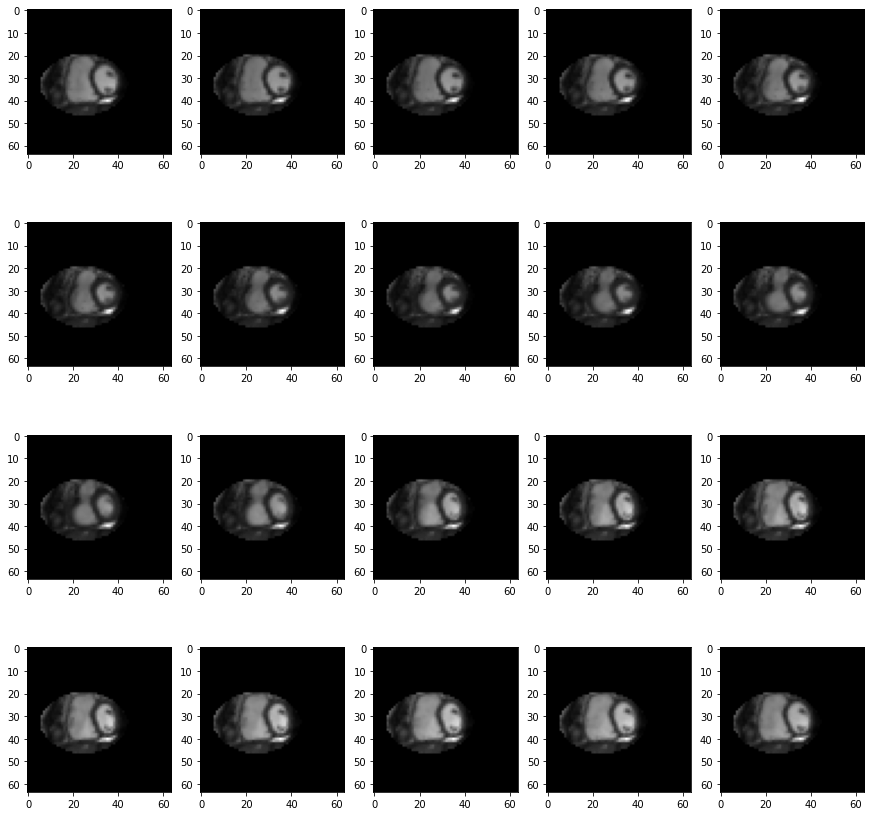

In [12]:
#Plotting masked images
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(img_masked[i][j-1], cmap="gray")

In [13]:
img_rescaled = rescale_img_stack(img_masked.copy(), scale=1 / 2)

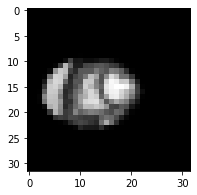

In [14]:
fig = plt.figure(figsize=(3,3))
plt.imshow(img_rescaled[0][0], cmap='gray')
plt.savefig('image_rescaled', format='jpg')

In [15]:
img_norm = normalize_img_stack(img_rescaled.copy())

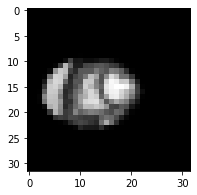

In [16]:
fig = plt.figure(figsize=(3,3))
plt.imshow(img_norm[0][0], cmap='gray')
plt.savefig('image_norm', format='jpg')

In [22]:
x = img_norm.copy() # creating copy to avoid modifying original images due to the pointer nature
x = torch.from_numpy(x)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [30]:
model = models.quantization.resnet18()
model.eval()

QuantizableResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_relu): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

In [31]:
out = model(X_train)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[125, 20, 32, 32] to have 3 channels, but got 20 channels instead